# Figures for Test 1

### Test 1: Cloud Temperature (Altitude)

#### Version 7a: 2024-07-25

* This version include logscale colorbar with SymLogNorm
* Temperature range from 236 K to 200 K for cloud middle level.
* Ice Optical Schemes (index associated with config file):
        5.1 Fu 1996 and Fu, Yang & Sun 1998 (Fu: 1O).
        5.2 Yi et al. 2013 (Yi13: 2O).
        5.3 Baran et al. 2016 (Baran16: 3O).
        5.4 Baran et al. 2014 (Baran14: 4O).

### Loading Libraries

In [1]:
import numpy as np # Version used here: 1.23.4 (python 3.8.15)
import pandas as pd # Version used here: 1.5.2 (python 3.8.15)
import xarray as xr # Version used here: 2022.11.0 (python 3.8.15)
from scipy import interpolate # Version used here: 1.10.0 (python 3.8.15)

import matplotlib.pyplot as plt # Version used here: 3.6.2 (python 3.8.15)
import matplotlib.colors as colors

# Project utilities
from project_utilites import crh_diff, crh_rdiff, colorbar_range, cloud_range

%matplotlib notebook

In [2]:
test    = 'test1'
version = 'v7a'

## Reading data

In [3]:
ecrad_ref_data = xr.open_dataset('2-ecrad_outputs/output_1Dset_' + test + '_1O_' + version + '.nc')
crh_data       = xr.open_dataset('3-crh_matrices/CRH_1Dset_' + test + '_' + version + '.nc')

crh_sw  = crh_data.crh_sw.values
crh_lw  = crh_data.crh_lw.values
crh_net = crh_data.crh_net.values

In [4]:
tropical_profile = pd.read_csv('tropical_profile_ellingson_250m.txt', sep='\s+ ',
                               engine = 'python')

In [5]:
temp_int       = interpolate.interp1d(tropical_profile['pressure (hPa)'].iloc[::-1]*100,
                                      tropical_profile['temperature (K)'].iloc[::-1])
temperature_hl = temp_int(ecrad_ref_data.pressure_hl.values)

altitude_int   = interpolate.interp1d(tropical_profile['pressure (hPa)'].iloc[::-1]*100,
                                      tropical_profile['height (km)'].iloc[::-1])
altitude_hl    = altitude_int(ecrad_ref_data.pressure_hl.values)

In [6]:
temp            = pd.Series(temperature_hl[0])
tropopause_i    = temp.argmin()
upper_limit_i   = (temp.iloc[tropopause_i:] - 201).abs().argmin()
lower_limit_i   = (temp.iloc[tropopause_i:] - 236).abs().argmin()
temp_range      = temp.iloc[tropopause_i+upper_limit_i:tropopause_i+lower_limit_i+1]
melting_layer_i = (temp - 273.15).abs().argmin()
melting_layer   = temp.iloc[melting_layer_i]
tropopause      = temp.min()

altitude_hl_pd  = pd.Series(altitude_hl[0])

## Figure S4 (CRHs):

In [7]:
print(crh_sw.max())
print(crh_lw.max())
print(crh_net.max())
print(crh_sw.min())
print(crh_lw.min())
print(crh_net.min())

13.161953649981193
48.26374677358128
52.819262791782826
-0.6960812531738134
-10.369691960485852
-3.968654216357789


For SymLogNorm:

In [14]:
vmin, vmax, linthresh, linscale, maj_tickbar, min_tickbar = colorbar_range(crh_data, test, diff = False)

Manual correction:

In [15]:
maj_tickbar  = [-10, 0, 10]

Max and min lines for each case:

In [16]:
datain_path  = '1-ecrad_inputs/'
sw_ranges, lw_ranges, net_ranges = cloud_range(datain_path, test, version, crh_data, diff = False)

<IPython.core.display.Javascript object>


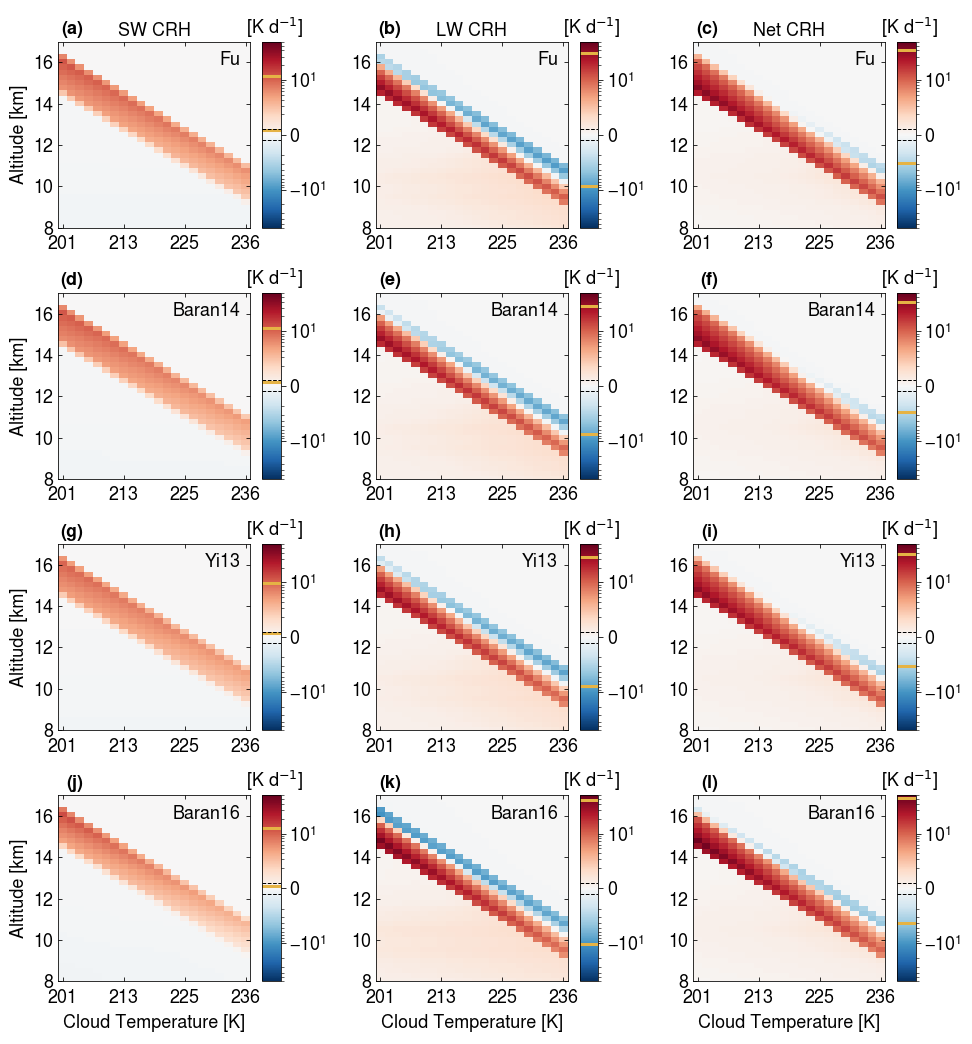

In [22]:
fontname = 'Nimbus Sans' # Arial
fontsize = 18
fheigth  = 14.5 # inches
flength  = 13.5 # inches

rows    = 4
columns = 3
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.96, bottom = 0.06, left = 0.06, right = 0.96, 
                    hspace = .35, wspace = .325)

# Colorbar label position
labelpad     = -52
cb_label_pos = 1.14

Sch_order = [0, 3, 1, 2] # Fu, Baran14, Yi13 and Baran16
for opt in range(rows):
    sch = Sch_order[opt]
    coli = 0
    for comp in ['sw', 'lw', 'net']:
        im = ax[opt, coli].imshow(eval('crh_' + comp)[sch], 
                                  cmap = 'RdBu_r', aspect = 'auto',
                                  norm = colors.SymLogNorm(linthresh, linscale, base = 10,
                                                           vmin = vmin, vmax = vmax)) 
        cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
        cbar.ax.axhline(eval(comp + '_ranges')[sch, 0], c = (229/255, 179/255, 69/255), linewidth = 3)
        cbar.ax.axhline(eval(comp + '_ranges')[sch, 1], c = (229/255, 179/255, 69/255), linewidth = 3)
        cbar.ax.axhline(linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
        cbar.ax.axhline(-linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
        cbar.set_label(r'[K d$^{-1}$]', labelpad = labelpad, y = cb_label_pos, rotation=0, 
                       fontsize = fontsize, fontname = fontname)
        cbar.ax.yaxis.set_ticks(maj_tickbar, major = True)
        cbar.ax.yaxis.set_ticks(min_tickbar, minor = True)
        cbar.ax.tick_params(labelsize = fontsize, which = 'major', length = 5)
        cbar.ax.tick_params(which = 'minor', length = 2.5)
        for tick in cbar.ax.get_yticklabels():
            tick.set_fontname(fontname)
        if opt == 0:
            if comp == 'net': frame_title = comp.capitalize()
            else: frame_title = comp.upper()
            ax[opt, coli].set_title(frame_title + ' CRH', color = 'black',
                                    fontsize = fontsize, fontname = fontname,
                                    y = 1)
        coli += 1

# AXIS PARAMETERS
# Y Axis: altitude tickLabels are rounded for visualization:
yticks      = np.arange(0, crh_net.shape[1] + 1, 8) # altitude tick labels
yticklabels = (altitude_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis:
xticks      = np.arange(0, 28, 7)
xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()
    
OptSch          = ['Fu', 'Yi13', 'Baran16', 'Baran14']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)']
panel_letters_i = 0
for opt in range(rows):
    sch = Sch_order[opt]
    for j in range(columns):
        # Horizontal Lines:
        #h = ax[j,i].axhline(y = melting_layer_i, linestyle = 'dashed', color = 'grey',
        #                    dashes = (3, 2), linewidth  =2)
        #h = ax[j,i].axhline(y = tropopause_i, linestyle = 'dashed', color = 'grey',
        #                    dashes = (3, 2), linewidth  =2)
        if opt == 3:
            ax[opt, j].set_xlabel(r'Cloud Temperature [K]', 
                                  fontsize = fontsize, fontname = fontname,
                                  color ='black', labelpad = 7.5)
        ax[opt, j].tick_params(axis = 'x', which = 'major', color = 'black',
                               size = 4, direction = 'in', top = True,
                               labelsize = fontsize, pad = 7.5)
        for tick in ax[opt, j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[opt, j].set_xticks(xticks)
        ax[opt, j].set_xticklabels(xticklabels) #[::-1]
        ax[opt, j].tick_params(axis = 'y', which = 'major', color = 'black',
                               size = 4, direction = 'in', right = True,
                               labelsize = fontsize, pad = 5)
        for tick in ax[opt, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[opt, j].set_yticks(yticks)
        ax[opt, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[opt, j].set_ylabel('Altitude [km]', fontsize = fontsize, fontname = fontname,
                                  color ='black', labelpad = 5)
        ax[opt, j].text(0.95, 0.95, OptSch[sch],
                        ha = 'right', va = 'top', transform = ax[opt, j].transAxes,
                        fontsize = fontsize, fontname = fontname, color = 'black')

        ax[opt, j].set_ylim((altitude_hl_pd - 8).abs().argmin(), (altitude_hl_pd - 17).abs().argmin())
        
        # Panel letters:
        ax[opt, j].text(0.13, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                        ha = 'right', va = 'top', transform = ax[opt, j].transAxes,
                        fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1
        
# Save Figure:
#plt.savefig('paper_figures/fs04.pdf', dpi = 300)

## Figure 1. CRH by Fu

In [ ]:
print(crh_sw[0].max())
print(crh_lw[0].max())
print(crh_net[0].max())
print(crh_sw[0].min())
print(crh_lw[0].min())
print(crh_net[0].min())

For SymLogNorm (Only considering Fu scheme in this case):

In [ ]:
vmin, vmax, linthresh, linscale, maj_tickbar, min_tickbar = colorbar_range(crh_data.sel(scheme = 0))

Max and min lines for each case:

In [ ]:
datain_path  = '1-ecrad_inputs/'
sw_ranges, lw_ranges, net_ranges = cloud_range(datain_path, test, version, crh_data, diff = False)

In [ ]:
fontname = 'Nimbus Sans' # Arial
fontsize = 18
flength  = 13.5 # inches
fheigth  = 3.8 # inches

rows    = 1
columns = 3
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.88, bottom = 0.22, left = 0.07, right = 0.96, 
                    hspace = .35, wspace = .325)

# Colorbar label position
labelpad     = -52
cb_label_pos = 1.14

coli = 0
for comp in ['sw', 'lw', 'net']:
    im = ax[coli].imshow(eval('crh_' + comp)[0], 
                         cmap = 'RdBu_r', aspect = 'auto',
                         norm = colors.SymLogNorm(linthresh, linscale, base = 10,
                                                  vmin = vmin, vmax = vmax)) 
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
    cbar.ax.axhline(eval(comp + '_ranges')[0, 0], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(eval(comp + '_ranges')[0, 1], c = (229/255, 179/255, 69/255), linewidth = 3)
    cbar.ax.axhline(linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.ax.axhline(-linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
    cbar.set_label(r'[K d$^{-1}$]', labelpad = labelpad, y = cb_label_pos, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.yaxis.set_ticks(maj_tickbar, major = True)
    cbar.ax.yaxis.set_ticks(min_tickbar, minor = True)
    cbar.ax.tick_params(labelsize = fontsize, which = 'major', length = 5)
    cbar.ax.tick_params(which = 'minor', length = 2.5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if comp == 'net': frame_title = comp.capitalize()
    else: frame_title = comp.upper()
    ax[coli].set_title(frame_title + ' CRH', color = 'black',
                       fontsize = fontsize, fontname = fontname,
                       y = 1)
    coli += 1

# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, crh_net.shape[1] + 1, 8) # altitude tick labels
# height tickLabels are rounded for visualization:
yticklabels = (altitude_hl_pd.loc[yticks].round(1) - .1).astype('int').to_list()
    
# X Axis:
xticks      = np.arange(0, 28, 7) # 21 elements max
xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()

#OptSch_sw       = ['Fu 1996', 'Yi et al. 2013', 'Baran et al. 2016']
#OptSch_lw       = ['Fu, Yang & Sun 1998', 'Yi et al. 2013', 'Baran et al. 2016']
#OptSch          = ['Fu 1996, 1998', 'Yi et al. 2013', 'Baran et al. 2016']
OptSch          = ['Fu', 'Yi13', 'Baran16']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)']
panel_letters_i = 0
for j in range(columns):
    # Horizontal Lines:
    #h = ax[j,i].axhline(y = melting_layer_i, linestyle = 'dashed', color = 'grey',
    #                    dashes = (3, 2), linewidth  =2)
    #h = ax[j,i].axhline(y = tropopause_i, linestyle = 'dashed', color = 'grey',
    #                    dashes = (3, 2), linewidth  =2)
    ax[j].set_xlabel(r'Cloud Temperature [K]', 
                     fontsize = fontsize, fontname = fontname,
                     color ='black', labelpad = 7.5)
    ax[j].tick_params(axis = 'x', which = 'major', color = 'black',
                      size = 4, direction = 'in', top = True,
                      labelsize = fontsize, pad = 10)
    for tick in ax[j].get_xticklabels():
        tick.set_fontname(fontname)
    ax[j].set_xticks(xticks)
    ax[j].set_xticklabels(xticklabels) #[::-1]
    ax[j].tick_params(axis = 'y', which = 'major', color = 'black',
                      size = 4, direction = 'in', right = True,
                      labelsize = fontsize, pad = 10)
    for tick in ax[j].get_yticklabels():
        tick.set_fontname(fontname)
    ax[j].set_yticks(yticks)
    ax[j].set_yticklabels(yticklabels)
    if j == 0:
        ax[j].set_ylabel('Altitude [km]', fontsize = fontsize, fontname = fontname,
                         color ='black', labelpad = 10)
#         ax[j].text(0.95, 0.95, OptSch_sw[0],
#                    ha = 'right', va = 'top', transform = ax[j].transAxes,
#                    fontsize = fontsize, fontname = fontname, color = 'black')
#     if j == 1:
#         ax[j].text(0.95, 0.95, OptSch_lw[0],
#                    ha = 'right', va = 'top', transform = ax[j].transAxes,
#                    fontsize = fontsize, fontname = fontname, color = 'black')
#     if j == 2:
#         ax[j].text(0.95, 0.95, OptSch[0],
#                    ha = 'right', va = 'top', transform = ax[j].transAxes,
#                    fontsize = fontsize, fontname = fontname, color = 'black')
    ax[j].set_ylim((altitude_hl_pd - 8).abs().argmin(), (altitude_hl_pd - 17).abs().argmin())
    # Panel letters:
    ax[j].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
               ha = 'right', va = 'top', transform = ax[j].transAxes,
               fontsize = fontsize, fontname = fontname, color = 'black')
    panel_letters_i += 1


# Save Figure:
#plt.savefig('paper_figures/f01.pdf', dpi = 300)

## Figure 2. CRH interscheme difference:

In [ ]:
crh_diff_ds = crh_diff(crh_data, test)

In [ ]:
crh_diff_ds

In [ ]:
# Shortwave CRH differences:
print('Shortwave CRH Differences:')
print('Yi - Fu max: ', crh_diff_ds.crhd_sw.values[0].max())
print('Yi - Fu min: ', crh_diff_ds.crhd_sw.values[0].min())
print('Baran2014 - Fu max: ', crh_diff_ds.crhd_sw.values[2].max())
print('Baran2014 - Fu min: ', crh_diff_ds.crhd_sw.values[2].min())
print('Baran2016 - Fu max: ', crh_diff_ds.crhd_sw.values[1].max())
print('Baran2016 - Fu min: ', crh_diff_ds.crhd_sw.values[1].min())

print('')
# Longwave CRH differences:
print('Longwave CRH Differences:')
print('Yi - Fu max: ', crh_diff_ds.crhd_lw.values[0].max())
print('Yi - Fu min: ', crh_diff_ds.crhd_lw.values[0].min())
print('Baran2014 - Fu max: ', crh_diff_ds.crhd_lw.values[2].max())
print('Baran2014 - Fu min: ', crh_diff_ds.crhd_lw.values[2].min())
print('Baran2016 - Fu max: ', crh_diff_ds.crhd_lw.values[1].max())
print('Baran2016 - Fu min: ', crh_diff_ds.crhd_lw.values[1].min())

print('')
# Net CRH differences:
print('Net CRH Differences:')
print('Yi - Fu max: ', crh_diff_ds.crhd_net.values[0].max())
print('Yi - Fu min: ', crh_diff_ds.crhd_net.values[0].min())
print('Baran2014 - Fu max: ', crh_diff_ds.crhd_net.values[2].max())
print('Baran2014 - Fu min: ', crh_diff_ds.crhd_net.values[2].min())
print('Baran2016 - Fu max: ', crh_diff_ds.crhd_net.values[1].max())
print('Baran2016 - Fu min: ', crh_diff_ds.crhd_net.values[1].min())

For SymLogNorm (Only considering Fu scheme in this case):

In [ ]:
vmin, vmax, linthresh, linscale, maj_tickbar, min_tickbar = colorbar_range(crh_diff_ds)

In [ ]:
vmin, vmax, linthresh, linscale

Values can be adjusted if the function doesn't give a reasonable colorbar parameters:

In [ ]:
linthresh = .1
linscale  = .25

Max and min lines for each case:

In [ ]:
datain_path = '1-ecrad_inputs/'
sw_ranges, lw_ranges, net_ranges = cloud_range(datain_path, test, version, crh_diff_ds, diff = True)

In [ ]:
sw_ranges, lw_ranges, net_ranges

In [ ]:
fontname = 'Nimbus Sans' # Arial
fontsize = 18
fheigth  = 10.75 # inches
flength  = 13.5 # inches

rows    = 3
columns = 3
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.95, bottom = 0.08, left = 0.075, right = 0.95, 
                    hspace = .35, wspace = .325)

labelpad     = -52
cb_label_pos = 1.14
IntSch_order = [2, 0, 1] # Baran2014 - Fu, Yi - Fu and Baran2016 - Fu
for opt in range(rows):
    isch = IntSch_order[opt]
    coli = 0
    for comp in ['sw', 'lw', 'net']:
        im = ax[opt, coli].imshow(crh_diff_ds['crhd_' + comp][isch], 
                                  cmap = 'RdBu_r', aspect = 'auto',
                                  norm = colors.SymLogNorm(linthresh, linscale, base = 10,
                                                           vmin = vmin, vmax = vmax)) 
        cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
        cbar.ax.axhline(eval(comp + '_ranges')[isch, 0], c = (229/255, 179/255, 69/255), linewidth = 3)
        cbar.ax.axhline(eval(comp + '_ranges')[isch, 1], c = (229/255, 179/255, 69/255), linewidth = 3)
        cbar.ax.axhline(linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
        cbar.ax.axhline(-linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
        cbar.set_label(r'[K d$^{-1}$]', labelpad = labelpad, y = cb_label_pos, rotation=0, 
                       fontsize = fontsize, fontname = fontname)
        cbar.ax.yaxis.set_ticks(maj_tickbar, major = True)
        cbar.ax.yaxis.set_ticks(min_tickbar, minor = True)
        cbar.ax.tick_params(labelsize = fontsize, which = 'major', length = 5)
        cbar.ax.tick_params(which = 'minor', length = 2.5)
        for tick in cbar.ax.get_yticklabels():
            tick.set_fontname(fontname)
        if opt == 0:
            if comp == 'net': frame_title = comp.capitalize()
            else: frame_title = comp.upper()
            ax[opt, coli].set_title(frame_title + ' CRH Diff.', color = 'black',
                                    fontsize = fontsize, fontname = fontname,
                                    y = 1)
        coli += 1

# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, crh_diff_ds['crhd_net'].shape[1] + 1, 8) # altitude tick labels
# height tickLabels are rounded for visualization:
yticklabels = (altitude_hl_pd.loc[yticks].round(1) - .1).astype('int').to_list()
    
# X Axis:
xticks      = np.arange(0, 28, 7) # 21 elements max
xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()

Diff            = ['Yi13 - Fu', 'Baran16 - Fu', 'Baran14 - Fu']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)']
panel_letters_i = 0
for diff in range(rows):
    IntSch = IntSch_order[diff]
    for j in range(columns):
        if diff == 2:
            ax[diff, j].set_xlabel(r'Cloud Temperature [K]', 
                                   fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 7.5)
        ax[diff, j].tick_params(axis = 'x', which = 'major', color = 'black',
                                size = 4, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_xticks(xticks)
        ax[diff, j].set_xticklabels(xticklabels) #[::-1]
        ax[diff, j].tick_params(axis = 'y', which = 'major', color = 'black',
                                size = 4, direction = 'in', right = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_yticks(yticks)
        ax[diff, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[diff, j].set_ylabel('Altitude [km]', fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 10)
        ax[diff, j].text(0.95, 0.95, Diff[IntSch],
                         ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        ax[diff, j].set_ylim((altitude_hl_pd - 8).abs().argmin(), (altitude_hl_pd - 17).abs().argmin())
        # Panel letters:
        ax[diff, j].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                         ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1


# Save Figure:
#plt.savefig('paper_figures/f02.pdf', dpi = 300)

## CRH interscheme RELATIVE difference:

In [ ]:
crh_rdiff_ds = crh_rdiff(crh_diff_ds, crh_data, test)

For SymLogNorm (Only considering Fu scheme in this case):

In [ ]:
vmin, vmax, linthresh, linscale, maj_tickbar, min_tickbar = colorbar_range(crh_rdiff_ds)

In [ ]:
vmin, vmax, linthresh, linscale

Values can be adjusted if the function doesn't give a reasonable colorbar parameters:

In [ ]:
vmin      = -35
vmax      = 35
linthresh = .001
linscale  = .1

Max and min lines for each case:

In [ ]:
datain_path = 'ecrad_inputs/'
test        = 'test1'
version     = 'v7a'
sw_ranges, lw_ranges, net_ranges = cloud_range(datain_path, test, version, crh_rdiff_ds, diff = True)

In [ ]:
sw_ranges, lw_ranges, net_ranges

In [ ]:
fontname = 'Nimbus Sans' # Arial
fontsize = 18
fheigth  = 10.75 # inches
flength  = 13.5 # inches

rows    = 3
columns = 3
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.95, bottom = 0.08, left = 0.075, right = 0.95, 
                    hspace = .35, wspace = .325)

labelpad     = -52
cb_label_pos = 1.14
IntSch_order = [2, 0, 1] # Baran2014 - Fu, Yi - Fu and Baran2016 - Fu
for opt in range(rows):
    isch = IntSch_order[opt]
    coli = 0
    for comp in ['sw', 'lw', 'net']:
        im = ax[opt, coli].imshow(crh_rdiff_ds['crhrd_' + comp][isch], 
                                  cmap = 'RdBu_r', aspect = 'auto',
                                  norm = colors.SymLogNorm(linthresh, linscale, base = 10,
                                                           vmin = vmin, vmax = vmax)) 
        cbar = plt.colorbar(im, aspect = 10, pad = 0.05)
        cbar.ax.axhline(eval(comp + '_ranges')[isch, 0], c = (229/255, 179/255, 69/255), linewidth = 3)
        cbar.ax.axhline(eval(comp + '_ranges')[isch, 1], c = (229/255, 179/255, 69/255), linewidth = 3)
        cbar.ax.axhline(linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
        cbar.ax.axhline(-linthresh, c = 'black', linewidth = 1, linestyle = 'dashed')
#         cbar.set_label(r'[%]', labelpad = labelpad, y = cb_label_pos, rotation=0, 
#                        fontsize = fontsize, fontname = fontname)
        cbar.ax.yaxis.set_ticks(maj_tickbar, major = True)
        cbar.ax.yaxis.set_ticks(min_tickbar, minor = True)
        cbar.ax.tick_params(labelsize = fontsize, which = 'major', length = 5)
        cbar.ax.tick_params(which = 'minor', length = 2.5)
        for tick in cbar.ax.get_yticklabels():
            tick.set_fontname(fontname)
        if opt == 0:
            if comp == 'net': frame_title = comp.capitalize()
            else: frame_title = comp.upper()
            ax[opt, coli].set_title(frame_title + ' CRH Rel. Diff.', color = 'black',
                                    fontsize = fontsize, fontname = fontname,
                                    y = 1)
        coli += 1

# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, crh_rdiff_ds['crhrd_net'].shape[1] + 1, 8) # altitude tick labels
# height tickLabels are rounded for visualization:
yticklabels = (altitude_hl_pd.loc[yticks].round(1) - .1).astype('int').to_list()
    
# X Axis:
xticks      = np.arange(0, 28, 7) # 21 elements max
xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()

Diff            = ['Yi13 - Fu', 'Baran16 - Fu', 'Baran14 - Fu']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)']
panel_letters_i = 0
for diff in range(rows):
    IntSch = IntSch_order[diff]
    for j in range(columns):
        if diff == 2:
            ax[diff, j].set_xlabel(r'Cloud Temperature [K]', 
                                   fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 7.5)
        ax[diff, j].tick_params(axis = 'x', which = 'major', color = 'black',
                                size = 4, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_xticks(xticks)
        ax[diff, j].set_xticklabels(xticklabels) #[::-1]
        ax[diff, j].tick_params(axis = 'y', which = 'major', color = 'black',
                                size = 4, direction = 'in', right = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_yticks(yticks)
        ax[diff, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[diff, j].set_ylabel('Altitude [km]', fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 10)
        ax[diff, j].text(0.95, 0.95, Diff[IntSch],
                         ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        ax[diff, j].set_ylim((altitude_hl_pd - 8).abs().argmin(), (altitude_hl_pd - 17).abs().argmin())
        # Panel letters:
        ax[diff, j].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                         ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1


# Save Figure:
#plt.savefig('paper_figures/f02.pdf', dpi = 300)